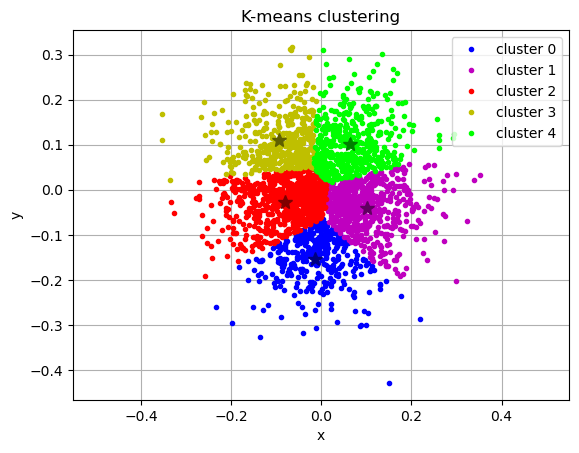

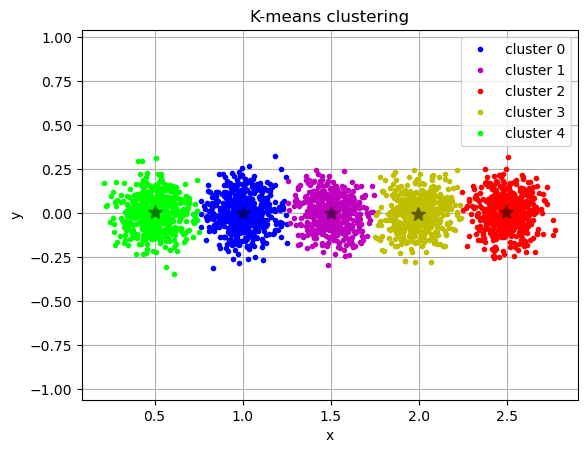

In [8]:
from clustering_utils import gaussian_cluster, draw_clusters, distance
from typing import Union, List
import numpy as np
import random


class KMeans:
    """
    Метод К-средних соседей.
    Этапы алгоритма:
    1. Выбирается число кластеров k.
    2. Из исходного множества данных случайным образом выбираются k наблюдений,
       которые будут служить начальными центрами кластеров.
    3. Для каждого наблюдения исходного множества определяется ближайший к нему центр кластера
       (расстояния измеряются в метрике Евклида). При этом записи,
        «притянутые» определенным центром, образуют начальные кластеры
    4. Вычисляются центроиды — центры тяжести кластеров. Каждый центроид — это вектор, элементы которого
       представляют собой средние значения соответствующих признаков, вычисленные по всем записям кластера.
    5. Центр кластера смещается в его центроид, после чего центроид становится центром нового кластера.
    6. 3-й и 4-й шаги итеративно повторяются. Очевидно, что на каждой итерации происходит изменение границ
       кластеров и смещение их центров. В результате минимизируется расстояние между элементами внутри
       кластеров и увеличиваются между-кластерные расстояния.
                
    """
    def distance(self, a: np.ndarray, b: np.ndarray) -> float:
        """
        Расстояние между двумя точками. Используется Евклидово расстояние.
        """
        return np.linalg.norm(a - b)
    def __init__(self, n_clusters: int):
        """
        Метод к-средних соседей.
        """
        """
        Количество кластеров, которые ожидаем обнаружить.
        """
        self._n_clusters: int = n_clusters
        """
        Данные для кластеризации. Поле инициализируется при вызове метода fit.
        Например, если данные представляют собой координаты на плоскости,
        каждая отельная строка - это точка этой плоскости.
        """
        self._data: Union[np.ndarray, None] = None
        """
        Центры кластеров на текущем этапе кластеризации.
        """
        self._clusters_centers: Union[List[np.ndarray], None] = None
        """
        Список индексов строк из "_data", которые соответствуют определённому кластеру.
        Список списков индексов.
        """
        self._clusters_points_indices: Union[List[List[int]], None] = None
        """
        Расстояние между центроидом кластера на текущем шаге и предыдущем при котором завершается кластеризация.
        """
        self._distance_threshold: float = 0.0001

    @property
    def distance_threshold(self) -> float:
        return self._distance_threshold

    @distance_threshold.setter
    def distance_threshold(self, value: float) -> None:
        if not isinstance(value, (int, float)):
            raise TypeError("Distance threshold must be a numeric value.")
        if value < 0:
            raise ValueError("Distance threshold must be non-negative.")
        self._distance_threshold = value

    @property
    def n_clusters(self) -> int:
        return self._n_clusters

    @n_clusters.setter
    def n_clusters(self, value: int) -> None:
        if not isinstance(value, int):
            raise TypeError("Number of clusters must be an integer.")
        if value < 2:
            raise ValueError("Number of clusters must be at least 2.")
        self._n_clusters = value

    @property
    def n_samples(self) -> int:
        return self._data.shape[0] if self._data is not None else 0

    @property
    def n_features(self) -> int:
        return self._data.shape[1] if self._data is not None else 0

    @property
    def clusters(self) -> List[np.ndarray]:
        return [self._data[indices] for indices in self._clusters_points_indices]

    def _clear_current_clusters(self) -> None:
        self._clusters_centers = []
        self._clusters_points_indices = []

    def _create_start_clusters_centers(self) -> None:
        self._clear_current_clusters()
        clusters_ids = set()
        while len(clusters_ids) < self._n_clusters:
            cluster_id = random.randint(0, self.n_samples - 1)
            clusters_ids.add(cluster_id)
        self._clusters_centers = [self._data[idx] for idx in clusters_ids]

    def _get_closest_cluster_center(self, sample: np.ndarray) -> int:
        distances = [self.distance(sample, center) for center in self._clusters_centers]
        return np.argmin(distances)

    def _clusterize_step(self) -> List[np.ndarray]:
        self._clusters_points_indices = [[] for _ in range(self._n_clusters)]
        for idx, sample in enumerate(self._data):
            cluster_id = self._get_closest_cluster_center(sample)
            self._clusters_points_indices[cluster_id].append(idx)

        new_centers = [np.mean(self._data[indices], axis=0) for indices in self._clusters_points_indices]
        return new_centers

    def fit(self, data: np.ndarray, target_clusters: int = None) -> None:
        if not isinstance(data, np.ndarray):
            raise TypeError("Input data must be an instance of np.ndarray.")
        if data.ndim != 2:
            raise ValueError("Input data must be a 2-dimensional array.")

        self._data = data
        self._create_start_clusters_centers()

        prev_centers = np.zeros_like(self._clusters_centers)
        while np.linalg.norm(np.array(self._clusters_centers) - np.array(prev_centers)) > self._distance_threshold:
            prev_centers = np.array(self._clusters_centers)
            self._clusters_centers = self._clusterize_step()

    def show(self):
        draw_clusters(self.clusters, cluster_centers=self._clusters_centers, title="K-means clustering")


def separated_clusters():
    k_means = KMeans(5)
    clusters_data = np.vstack((gaussian_cluster(cx=0.5, n_points=512),
                               gaussian_cluster(cx=1.0, n_points=512),
                               gaussian_cluster(cx=1.5, n_points=512),
                               gaussian_cluster(cx=2.0, n_points=512),
                               gaussian_cluster(cx=2.5, n_points=512)))
    k_means.fit(clusters_data)
    k_means.show()


def merged_clusters():
    k_means = KMeans(5)
    k_means.fit(gaussian_cluster(n_points=512*5))
    k_means.show()

if __name__ == "__main__":
    """
    Сюрприз-сюрприз! Вызов функций "merged_clusters" и "separated_clusters".
    """
    merged_clusters()
    separated_clusters()
